In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set()

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
import keras
from tensorflow.keras import layers

# Loading & preprocessing the data

In [2]:
df = pd.read_csv('station_rio_preprocessed.csv')
df

,Temperature
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42
...,...
559,22.30
560,23.05
561,25.25
562,25.25


In [3]:
train_len = int(len(df)*0.8)
train_len

451

In [4]:
df_train = df.iloc[:train_len, :]
len(df_train)

451

In [5]:
df_test = df.iloc[train_len:, :]
len(df_test)

113

In [8]:
Xtrain = df_train['Temperature'].values

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
Xtrain_sc = scaler.fit_transform(Xtrain.reshape(-1, 1))
Xtrain_sc.shape

(451, 1)

In [11]:
Xtrain_f = []
Ytrain_f = []
time_step = 12

for i in range(time_step, len(Xtrain_sc)):
    Xtrain_f.append(Xtrain_sc[i - time_step:i, 0])
    Ytrain_f.append(Xtrain_sc[i, 0])
    
Xtrain_f = np.array(Xtrain_f)
Ytrain_f = np.array(Ytrain_f)

In [12]:
Xtrain_f = Xtrain_f.reshape(Xtrain_f.shape[0], Xtrain_f.shape[1], 1)
Xtrain_f.shape

(439, 12, 1)

# Building model

In [14]:
model = keras.Sequential([
    layers.LSTM(units = 128, return_sequences = True, input_shape = (Xtrain_f.shape[1], 1)),
    layers.LSTM(units = 64, return_sequences = False),
    layers.Dropout(0.2),
    
    layers.Dense(units = 25),
    layers.Dense(units = 1),
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [16]:
hist = model.fit(Xtrain_f, Ytrain_f, batch_size = 16, epochs = 10)

Epoch 1/10
28/28 [==============================] - 14s 26ms/step - loss: 0.0828
Epoch 2/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0591
Epoch 3/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0535
Epoch 4/10
28/28 [==============================] - 1s 24ms/step - loss: 0.0353
Epoch 5/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0243
Epoch 6/10
28/28 [==============================] - 1s 24ms/step - loss: 0.0195
Epoch 7/10
28/28 [==============================] - 1s 28ms/step - loss: 0.0181
Epoch 8/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0190
Epoch 9/10
28/28 [==============================] - 1s 24ms/step - loss: 0.0179
Epoch 10/10
28/28 [==============================] - 1s 22ms/step - loss: 0.0184


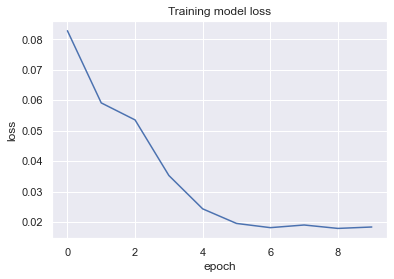

In [17]:
train_loss = hist.history['loss']
epochs = range(10)
plt.plot(epochs, train_loss)
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [18]:
Ytrain_pred = model.predict(Xtrain_f)

14/14 [==============================] - 2s 14ms/step


In [19]:
Ytrain_pred = scaler.inverse_transform(Ytrain_pred)

In [20]:
Ytrain_act = Xtrain[time_step:]

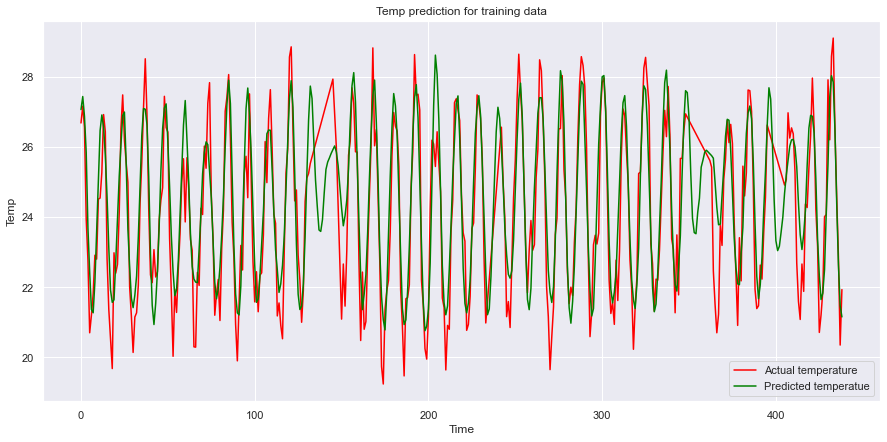

In [24]:
#plotting prediction for training data
plt.figure(figsize = (15, 7))
plt.plot(Ytrain_act, color = 'red', label = 'Actual temperature')
plt.plot(Ytrain_pred, color = 'green', label = 'Predicted temperatue')
plt.title('Temp prediction for training data')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.legend()
plt.show()

In [37]:
r2_score(Ytrain_act, Ytrain_pred)

0.7451574817772675

# Predictions for test data

In [40]:
Xtest = df_test['Temperature'].values

In [41]:
Xtest_sc = scaler.transform(Xtest.reshape(-1, 1))


In [42]:
Xtest_f = []

time_step = 12
for i in range(time_step, len(Xtest_sc)):
    Xtest_f.append(Xtest_sc[i - time_step: i, 0])
    
Xtest_f = np.array(Xtest_f)

In [43]:
Xtest_f = Xtest_f.reshape(Xtest_f.shape[0], Xtest_f.shape[1], 1)
Xtest_f.shape

(101, 12, 1)

In [44]:
Ypred = model.predict(Xtest_f)

4/4 [==============================] - 0s 11ms/step


In [45]:
Ypred = scaler.inverse_transform(Ypred)

In [46]:
Ytest = Xtest[time_step: ]

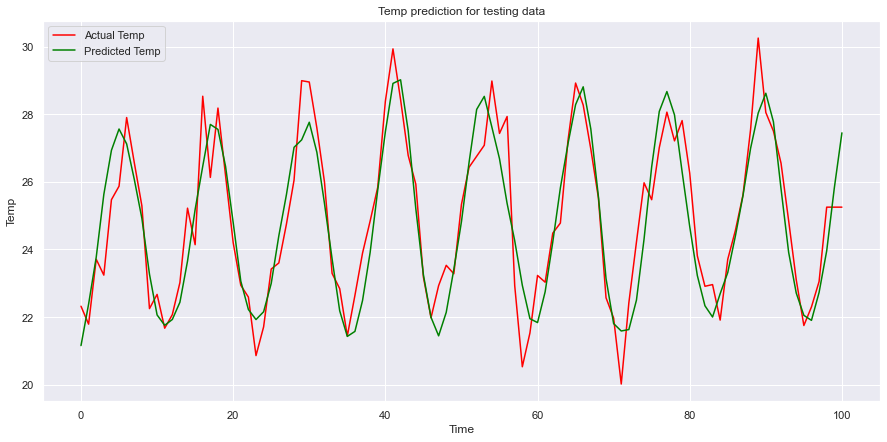

In [47]:
plt.figure(figsize = (15, 7))
plt.plot(Ytest, color = 'red', label = 'Actual Temp')
plt.plot(Ypred, color = 'green', label = 'Predicted Temp')
plt.title('Temp prediction for testing data')
plt.xlabel('Time')
plt.ylabel('Temp')
plt.legend()
plt.show()

In [48]:
r2_score(Ytest, Ypred)

0.8142359719286621